In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [2]:
# loading data
(X_train, y_train), (X_test, y_test) = tfds.load(
    "tf_flowers", split=["train[:75%]", "train[:25%]"],
    batch_size=-1, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
# resizing the data
X_train = tf.image.resize(X_train, (224, 224))
X_test = tf.image.resize(X_test, (224, 224))

In [4]:
# OHE on target
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [5]:
# getting the VGG16
ConvBase = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
ConvBase.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
# looking at the conf. of VGG16
ConvBase.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
# preprocessing the input in the desired format
X_train = preprocess_input(X_train) 
X_test = preprocess_input(X_test)

In [8]:
# model architecture
model = Sequential([
    ConvBase,
    Flatten(),
    Dense(40, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.1),
    Dense(20, activation='relu'),
    Dense(5, activation='softmax')
])

In [9]:
# getting a model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 40)                1003560   
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                        

In [10]:
# model compilation
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# training a model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
86/86 [==============================] - 28s 183ms/step - loss: 0.9579 - accuracy: 0.6548 - val_loss: 0.5061 - val_accuracy: 0.8083
Epoch 2/10
86/86 [==============================] - 15s 175ms/step - loss: 0.4718 - accuracy: 0.8474 - val_loss: 0.2583 - val_accuracy: 0.9161
Epoch 3/10
86/86 [==============================] - 15s 177ms/step - loss: 0.2718 - accuracy: 0.9197 - val_loss: 0.1424 - val_accuracy: 0.9630
Epoch 4/10
86/86 [==============================] - 14s 162ms/step - loss: 0.1775 - accuracy: 0.9488 - val_loss: 0.1116 - val_accuracy: 0.9782
Epoch 5/10
86/86 [==============================] - 16s 182ms/step - loss: 0.1341 - accuracy: 0.9597 - val_loss: 0.0850 - val_accuracy: 0.9793
Epoch 6/10
86/86 [==============================] - 14s 163ms/step - loss: 0.1021 - accuracy: 0.9717 - val_loss: 0.0419 - val_accuracy: 0.9946
Epoch 7/10
86/86 [==============================] - 14s 161ms/step - loss: 0.0644 - accuracy: 0.9826 - val_loss: 0.0259 - val_accuracy: 0.9946

In [12]:
# model evaluation
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy:', round(test_score[1] * 100, 2))

Accuracy: 98.47


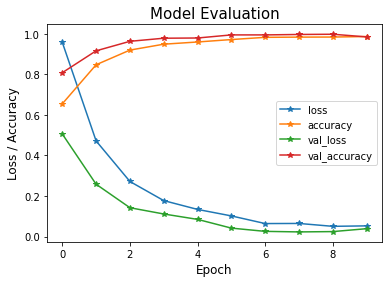

In [13]:
# plotting model performance
pd.DataFrame(history.history).plot(marker='*')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss / Accuracy', size=12)
plt.title('Model Evaluation', size=15);